<a href="https://colab.research.google.com/github/SaqibHussain06/Assignment1_Expense_Tracker_App/blob/master/Dataset_Overview_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Set-up

In [ ]:
!pip install matplotlib pandas numpy scipy seaborn mne
!pip install beautifulsoup4 requests wget
!pip install h5py tables kaggle
!pip install wfdb pyEDFlib

     |████████████████████████████████| 7.0MB 5.9MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=92a6a95915da366e80461ebda6fc1efab8c9922bfe7281a2c0161fff9661928f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 133kB 4.1MB/s 
     |████████████████████████████████| 1.3MB 7.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.22-cp37-cp37m-linux_x86_64.whl size=1520497 sha256=089aa4c19b4570a0458a6d23112df90d1120a2908ad93874dbd3b9179ea5a223
  Stored in directory: /root/.cache/pip/wheels/30/47/cc/d8725129b678c85e470f577e8fcac31e176e639deb64f9dcc1
Successfully built pyEDFlib


In [ ]:
# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
  
print(color.BOLD+color.UNDERLINE+'Title'+color.END)
print('Hello World')

Title
Hello World


Lets create a function to list all the files/directories it finds in a location and save them to a list.

In [ ]:
import glob            # for file locations
import pprint          # for pretty printing
import re

pp = pprint.PrettyPrinter()

def file_list(folder_path, output=False):
    # create an empty list
    file_list = []
    # for file name in the folder path...
    for filename in glob.glob(folder_path):
        # ... append it to the list
        file_list.append(filename)
        
    # sort alphabetically
    file_list.sort()
    
    # Output
    if output:
        print(str(len(file_list)) + " files found")
        pp.pprint(file_list)
    
    return file_list

# Downloading Dataset

In [ ]:
import sys
import os
from bs4 import BeautifulSoup
import requests
import re
import wget
import zipfile

def find_files(url):
    # get a soup of the directory url
    soup = BeautifulSoup(requests.get(url).text, features="html.parser")

    # make a list of all the links in the url
    hrefs_list = []
    for link in soup.find_all('a'):
        hrefs_list.append(link.get('href'))

    return hrefs_list
    
    
def download_file(download_file_url, file_dir, output=False):
    if output:
        # print it is downloading
        print('Downloading: '+ download_file_url)
    # download the file to the directory
    wget.download(download_file_url, file_dir)
    
    
# needs a directory to download it to
def download_epileptologie(DIR, output=False):
    
    # directory url
    front_url = 'http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3'
    dir_url = 'http://epileptologie-bonn.de/cms'

    hrefs_dir_list = find_files(front_url)
    
    # for each link in the directory
    for link in hrefs_dir_list:
        # download the files outside of participant folders we want
        if re.findall('zip', str(link)):
            # if the file doesnt already exist in the directory
            if not os.path.exists(os.path.join(DIR, link)):
                download_file(dir_url+'/'+str(link), DIR, output)
                zip_file_name = link.split('/')[-1]
                zip_ref = zipfile.ZipFile(os.path.join(DIR, zip_file_name), 'r')
                zip_ref.extractall(os.path.join(DIR, zip_file_name[0]))
                zip_ref.close()
                os.remove(os.path.join(DIR, zip_file_name))

In [ ]:
DOWNLOAD_DIR = "Epileptologie Database"

if not os.path.exists(DOWNLOAD_DIR):
  os.makedirs(DOWNLOAD_DIR)
  download_epileptologie(DOWNLOAD_DIR, output=True)

else:
  print("Already Downloaded")

Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/Z.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/O.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/N.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/F.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/S.zip


# Load Data

Lets have a look at intercranial EEG activity, recorded from within the "epileptogenic zone". The two files we will read in represent seizure and non-seizure brain activity. Lets create an object that represents their file path.

In [ ]:
# get folder lists
EPIL_dir_file_list = file_list(os.path.join(DOWNLOAD_DIR, '*'), output=True)

5 files found
['Epileptologie Database/F',
 'Epileptologie Database/N',
 'Epileptologie Database/O',
 'Epileptologie Database/S',
 'Epileptologie Database/Z']


In [ ]:
epil_baseline_file = os.path.join(EPIL_dir_file_list[0], 'F060.txt')
epil_seizure_file = os.path.join(EPIL_dir_file_list[3], 'S033.txt')

In [ ]:
epil_baseline_file

'Epileptologie Database/F/F060.txt'

In [ ]:
epil_seizure_file

'Epileptologie Database/S/S033.txt'

Lets create a function to read in the data as a Pandas DataFrame. These dataframes hold "2-dimensional labeled data structure with columns of potentially different types"1

In [ ]:
import pandas as pd     # dataframes
import re

def data_load(file_path, output=False):

    # read in the datafile
    data = pd.read_csv(file_path,                 # file in
                       header=None,               # no column names at top of file
                       dtype=float)               # read data as 'floating points' (e.g. 1.0)

    if output:
        print(color.BOLD+color.UNDERLINE+'\n'+re.findall('\w\d+',file_path)[0]+color.END)
        # Output detailed information on the data
        print(color.BOLD+'\nData Information'+color.END)
        data.info()

        # Output first 5 rows and columns
        print(color.BOLD+'\nDataframe Head'+color.END)
        display(data.head())
        
    return data
        

epil_baseline_df = data_load(epil_baseline_file, output=True)
epil_seizure_df = data_load(epil_seizure_file, output=True)


F060

Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4097 non-null   float64
dtypes: float64(1)
memory usage: 32.1 KB

Dataframe Head


,0
0,162.0
1,164.0
2,164.0
3,154.0
4,139.0



S033

Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4097 non-null   float64
dtypes: float64(1)
memory usage: 32.1 KB

Dataframe Head


,0
0,216.0
1,182.0
2,146.0
3,128.0
4,116.0


In [ ]:
#Importing MNE Library
import mne 

channel_name= ['CZ']
channel_type = ['eeg']
sample_rate = 173.61 # in hz

# create an mne info file with meta data about the EEG
info = mne.create_info(ch_names=channel_name, sfreq=sample_rate, 
                       ch_types=channel_type)

# show the info file
display(info)

<Info | 7 non-empty values
 bads: []
 ch_names: CZ
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 86.8 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 173.6 Hz
>

In [ ]:
#Converting data into volts from microvolts
def mne_object(data, info, output=False):
    data = data.apply(lambda x: x*1e-6)
    # transpose the data
    data_T = data.transpose()
    # create raw mne object
    raw = mne.io.RawArray(data_T, info)
    
    return raw

epil_baseline_mne = mne_object(epil_baseline_df, info, output=True)
epil_seizure_mne = mne_object(epil_seizure_df, info)

Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=4097
    Range : 0 ... 4096 =      0.000 ...    23.593 secs
Ready.


## Plot Data

Inter-Ictal
Setting up band-pass filter from 0.53 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.53, 40.00 Hz: -6.02, -6.02 dB



/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


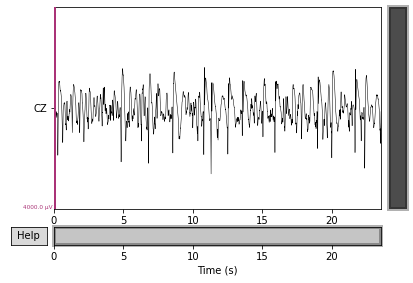

Ictal
Setting up band-pass filter from 0.53 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.53, 40.00 Hz: -6.02, -6.02 dB



/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


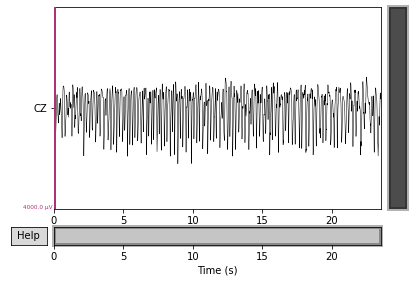

In [ ]:
plot_kwargs = {
    'scalings': dict(eeg=20e-4),   # zooms the plot out
    'highpass': 0.53,              # filters out low frequencies
    'lowpass': 40.,                # filters out high frequencies
    'n_channels': 1,               # just plot the one channel
    'duration': 24                 # number of seconds to plot
}

print(color.BOLD+color.UNDERLINE+"Inter-Ictal"+color.END)
epil_baseline_mne.plot(**plot_kwargs)
print(color.BOLD+color.UNDERLINE+"Ictal"+color.END)
epil_seizure_mne.plot(**plot_kwargs);

There is a lack of global definition of what "normal" EEG looks like; above represented by the Inter-Ictal data1. This is due to EEG changing over the course of a patients life, as well as between levels of cognition (e.g. awake/asleep) or behaviour (e.g. eyes open/closed). A common variation in EEG is found between awake and asleep EEG, where more global waveforms oscillate at slower frequencies across the head. This global activity is inter-dispersed with fast "spikes", which are commonly found in different sleep stages. The variability means EEG alone is rarely sufficient for a clinical diagnosis, with other diagnostic imaging and forms of observation often necessary.

Alike to "normal" EEG, there is a lot of variability found between and within different seizure types. Never-the-less, comparative to pre-seizure background EEG, seizures have the common traits of synchronisation across a few or many EEG channels, a large amplitude, and increased oscillatory activity. Onsets and offsets of seizures are typically abrupt, however variations can occur both between patients as well as between seizures. Patients may also have spiked inter-seizure discharges, which are short bursts of high amplitude, syncronized activity around an epileptic focus1.

Lets now randomly sample 9 files from each folder and plot them to get an idea of how they look.

In [ ]:
#Taking random 9 Files

In [2]:
import random
import matplotlib.pyplot as plt
from scipy import signal

for directory in EPIL_dir_file_list:
  #if re.findall('N|F|S',directory[-1]):
  # make a list of all the files in the directory
  files = file_list(os.path.join(directory, '*'))
  # randomly select 9 files from the list
  sampled_files = random.sample(files, 9)


  fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
  x=0
  y=0
  for file in sampled_files:

      # read in the datafile
      data = pd.read_csv(file,                      # file in
                          header=None,               # no column names at top of file
                          dtype=float)               # read data as 'floating points' (e.g. 1.0)

      # filter the data
      b, a = signal.butter(4, [1/(sample_rate/2), 30/(sample_rate/2)], 'bandpass', analog=False)
      filt_data = signal.filtfilt(b, a, data.T).T
      
      axs[x, y].plot(filt_data)
      axs[x, y].set_title(re.findall('\w\d+', file)[0], pad =-15)
      # plot all of them on the same scale
      axs[x, y].set_ylim([-2100, 2100])

      x+=1

      if x == 3:
          y +=1
          x=0


  # add a big axes, hide frame
  fig.add_subplot(111, frameon=False)
  # hide tick and tick label of the big axes
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  plt.grid(False)
  plt.xlabel("Datapoints", labelpad =0.5)
  plt.ylabel("Microvolts (uV)", labelpad =20)
  plt.subplots_adjust(wspace=0.1, hspace=0.1)    

  if directory[-1] == 'N':
      plt.title('Inter-ictal: Opposite Hippocampus')

  elif directory[-1] == 'F':
      plt.title('Inter-ictal: Epileptogenic Zone')

  elif directory[-1] == 'S':
      plt.title('Ictal: Epileptogenic Zone')
  
  elif directory[-1] == 'Z':
      plt.title('Surface EEG: Eyes Open')
  
  elif directory[-1] == 'O':
      plt.title('Surface EEG: Eyes Closed')

  plt.show()

NameError: ignored